In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import minimize
import seaborn as sns
import scipy.stats as stats

In [ ]:
# Load the dataset
file_path = "DataQ2.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1",engine='openpyxl')
# Ensure the date column is in datetime format
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
#df=df.iloc[::-1]
X=pd.to_datetime(df.iloc[:, 0])
df


,Date,AAPL,MSFT,IBM,NVDA,GOOGL,AMZN
0,2024-12-31,250.42,421.50,219.83,134.29,189.30,219.39
1,2024-12-30,252.20,424.83,220.25,137.49,191.24,221.30
2,2024-12-27,255.59,430.53,222.78,137.01,192.76,223.75
3,2024-12-26,259.02,438.11,224.89,139.93,195.60,227.05
4,2024-12-24,258.20,439.33,224.41,140.22,196.11,229.05
...,...,...,...,...,...,...,...
2763,2014-01-08,19.41,35.76,179.54,0.41,28.56,20.10
2764,2014-01-07,19.29,36.41,181.20,0.40,28.50,19.90
2765,2014-01-06,19.43,36.13,177.66,0.40,27.96,19.68
2766,2014-01-03,19.32,36.91,178.27,0.39,27.65,19.82


In [30]:
# Compute log returns
returns = np.log(df.iloc[:, 1:].shift(1) / df.iloc[:, 1:]).dropna()


In [59]:
# Split dataset into training and test sets
split_idx = len(returns) // 2
train_returns = returns.iloc[split_idx:]
test_returns = returns.iloc[:split_idx]
test_dates = df.iloc[:split_idx , 0]  # Adjust for dropped NaN
test_dates=test_dates.iloc[::-1, ]
test_dates

1382   2019-07-05
1381   2019-07-08
1380   2019-07-09
1379   2019-07-10
1378   2019-07-11
          ...    
4      2024-12-24
3      2024-12-26
2      2024-12-27
1      2024-12-30
0      2024-12-31
Name: Date, Length: 1383, dtype: datetime64[ns]

In [5]:
# Compute covariance matrix and volatilities
cov_matrix = train_returns.cov()
volatilities = train_returns.std()
n_assets = train_returns.shape[1]
init_weights = np.ones(n_assets) / n_assets
bounds = [(0, 1) for _ in range(n_assets)]
constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1}]

In [6]:
# Risk Parity Portfolio (Component VaR approach)
def compute_cvar(weights, returns, alpha=0.05):
    portfolio_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    asset_contributions = weights * (cov_matrix @ weights) / portfolio_vol
    cvar = asset_contributions / asset_contributions.sum()
    return np.std(cvar)

opt_rp = minimize(compute_cvar, init_weights, args=(train_returns,), method="SLSQP", bounds=bounds, constraints=constraints)
risk_parity_weights = opt_rp.x
risk_parity_weights

array([0.17636735, 0.16894164, 0.23478263, 0.1122478 , 0.16927668,
       0.1383839 ])

In [7]:
# Maximum Diversification Portfolio
def diversification_ratio(weights, volatilities, cov_matrix):
    portfolio_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    weighted_vol = np.sum(weights * volatilities)
    return -weighted_vol / portfolio_vol

opt_mdp = minimize(diversification_ratio, init_weights, args=(volatilities, cov_matrix), method="SLSQP", bounds=bounds, constraints=constraints)
max_div_weights = opt_mdp.x
max_div_weights

array([0.19987679, 0.04035726, 0.34855106, 0.15305913, 0.09502316,
       0.1631326 ])

In [8]:
# Equally Weighted Portfolio
equal_weights = np.ones(n_assets) / n_assets
equal_weights

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

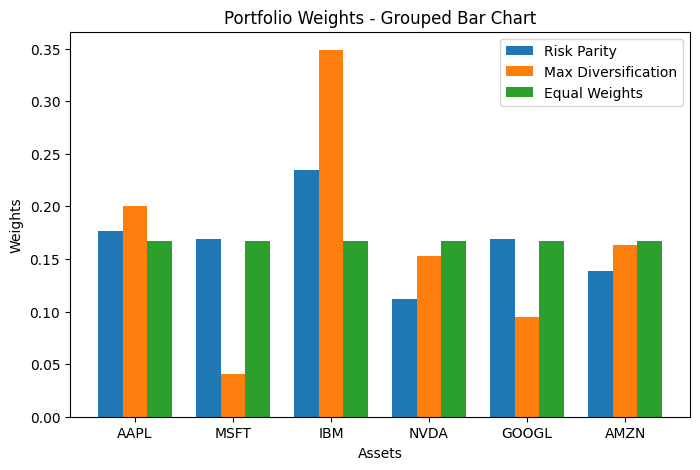

In [95]:
weights=[risk_parity_weights, max_div_weights, equal_weights]

assets = ['AAPL', 'MSFT', 'IBM', 'NVDA', 'GOOGL', 'AMZN']
# X locations for the groups
x = np.arange(len(assets))
width = 0.25  # Bar width

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width, weights[0], width, label='Risk Parity')
ax.bar(x, weights[1], width, label='Max Diversification')
ax.bar(x + width, weights[2], width, label='Equal Weights')

ax.set_xlabel("Assets")
ax.set_ylabel("Weights")
ax.set_title("Portfolio Weights - Grouped Bar Chart")
ax.set_xticks(x)
ax.set_xticklabels(assets)
ax.legend()
plt.savefig('weights.png')
plt.show()

In [9]:
# Compute Portfolio Returns
def portfolio_returns(weights, returns):
    return (returns @ weights).dropna()

rp_returns = portfolio_returns(risk_parity_weights, test_returns)
mdp_returns = portfolio_returns(max_div_weights, test_returns)
ew_returns = portfolio_returns(equal_weights, test_returns)

NON-PARAMETRIC APPROACH

In [26]:
# Performance Metrics
def compute_performance(portfolio_returns,var_95_NP, var_95_P):
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std()
    #cumulative_returns = (1+portfolio_returns).cumprod()
    cumulative_returns = portfolio_returns.cumsum()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    var_violationsNP = (portfolio_returns < var_95_NP).sum()
    var_violationsP = (portfolio_returns < var_95_P).sum()
    skewness = portfolio_returns.skew()  
    ExKu= portfolio_returns.kurtosis()
    return sharpe_ratio, max_drawdown, var_violationsNP, var_violationsP, skewness, ExKu

pf_returns_rp = portfolio_returns(risk_parity_weights, train_returns)
pf_returns_mdp = portfolio_returns(max_div_weights, train_returns)
pf_returns_ew = portfolio_returns(equal_weights, train_returns)
Z_Alpha= -1.645
var_95_rp_P = Z_Alpha*pf_returns_rp.std()+pf_returns_rp.mean()
var_95_mdp_P = Z_Alpha*pf_returns_mdp.std()+pf_returns_mdp.mean()
var_95_ew_P = Z_Alpha*pf_returns_ew.std()+pf_returns_ew.mean()

var_95_rp_NP = np.percentile(pf_returns_rp, 5)
var_95_mdp_NP = np.percentile(pf_returns_mdp, 5)
var_95_ew_NP = np.percentile(pf_returns_ew, 5)
rp_metrics = compute_performance(rp_returns,var_95_rp_NP,var_95_rp_P)
mdp_metrics = compute_performance(mdp_returns,var_95_mdp_NP,var_95_mdp_P)
ew_metrics = compute_performance(ew_returns,var_95_ew_NP,var_95_ew_P)

In [27]:
# Display results
performance_df = pd.DataFrame({
    "Portfolio": ["Risk Parity", "Max Diversification", "Equal Weight"],
    "Sharpe Ratio": [rp_metrics[0], mdp_metrics[0], ew_metrics[0]],
    "Max Drawdown": [rp_metrics[1], mdp_metrics[1], ew_metrics[1]],
    "VaR Violations with non-param approach": [rp_metrics[2], mdp_metrics[2], ew_metrics[2]],
    "VaR Violations with param approach": [rp_metrics[3], mdp_metrics[3], ew_metrics[3]],
    "Skewness": [rp_metrics[4], mdp_metrics[4], ew_metrics[4]],
    "Excess Kurtosis": [rp_metrics[5], mdp_metrics[5], ew_metrics[5]]
})

print(performance_df)

             Portfolio  Sharpe Ratio  Max Drawdown  \
0          Risk Parity      0.057762     -0.703953   
1  Max Diversification      0.059334     -6.547856   
2         Equal Weight      0.060840    -19.292575   

   VaR Violations with non-param approach  VaR Violations with param approach  \
0                                     106                                 121   
1                                      96                                 106   
2                                     121                                 126   

   Skewness  Excess Kurtosis  
0 -0.519803         6.588561  
1 -0.551991         6.693772  
2 -0.466187         5.528489  


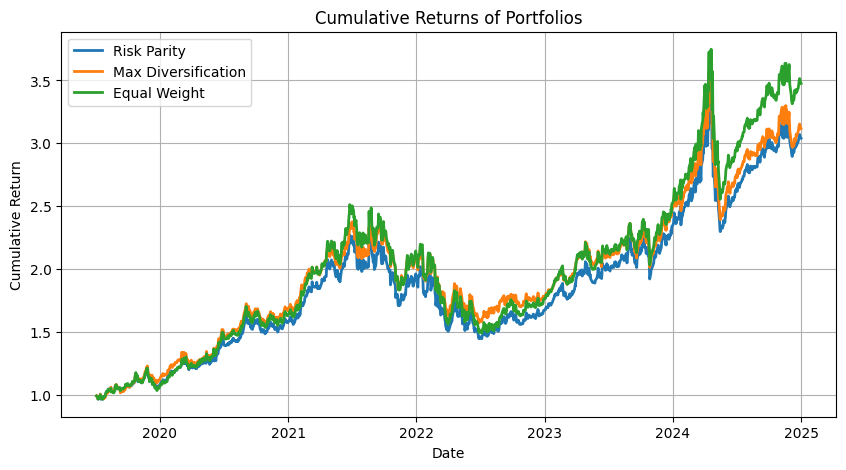

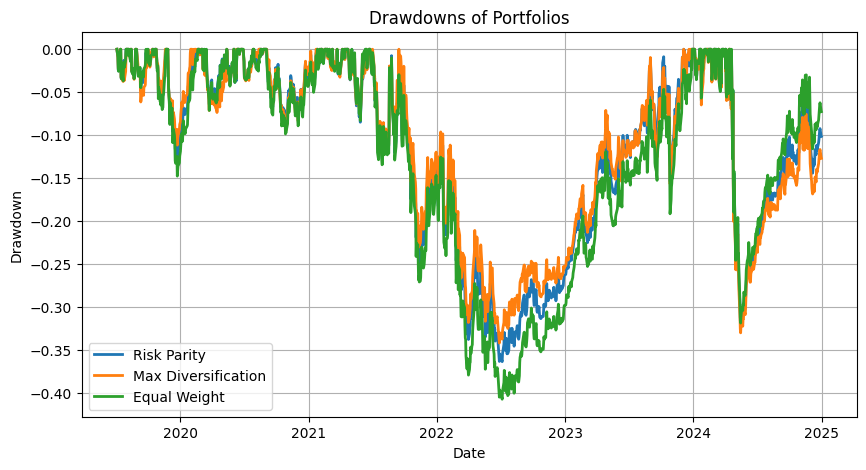

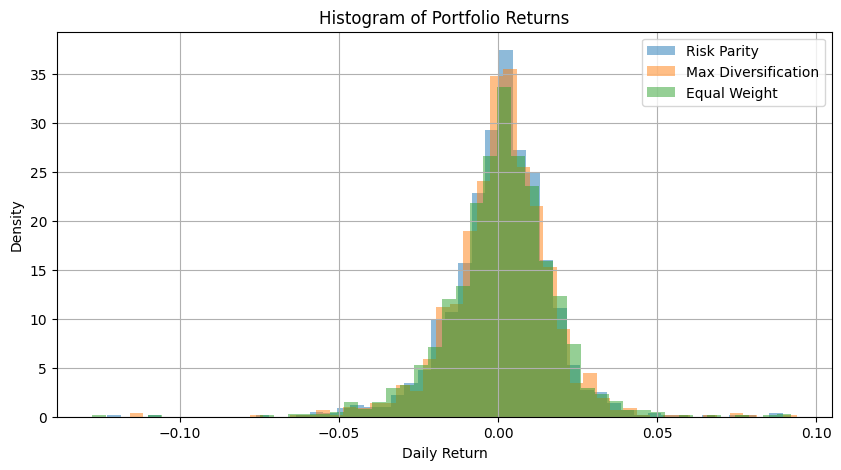

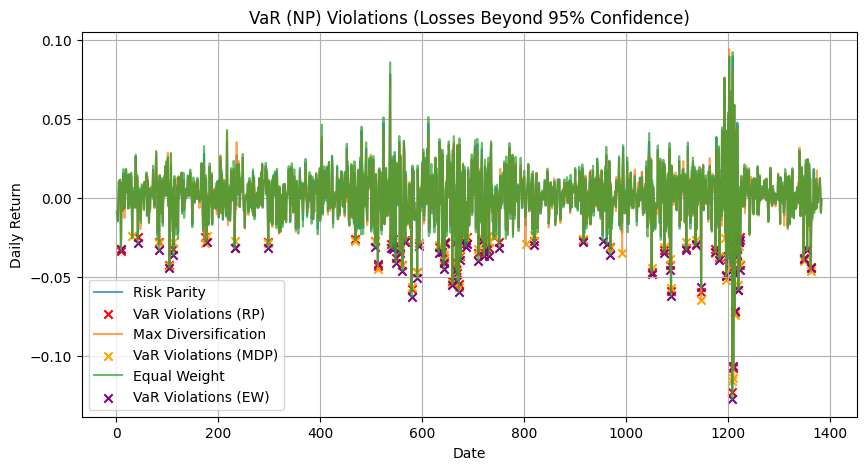

In [85]:
# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_dates,(1 + rp_returns).cumprod(), label="Risk Parity", linewidth=2)
plt.plot(test_dates,(1 + mdp_returns).cumprod(), label="Max Diversification", linewidth=2)
plt.plot(test_dates,(1 + ew_returns).cumprod(), label="Equal Weight", linewidth=2)
plt.title("Cumulative Returns of Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.savefig('returns_cum.png')
plt.show()

# Compute drawdowns
rp_drawdown = (1 + rp_returns).cumprod() / (1 + rp_returns).cumprod().cummax() - 1
mdp_drawdown = (1 + mdp_returns).cumprod() / (1 + mdp_returns).cumprod().cummax() - 1
ew_drawdown = (1 + ew_returns).cumprod() / (1 + ew_returns).cumprod().cummax() - 1

# Plot drawdowns
plt.figure(figsize=(10, 5))
plt.plot(test_dates,rp_drawdown, label="Risk Parity", linewidth=2)
plt.plot(test_dates,mdp_drawdown, label="Max Diversification", linewidth=2)
plt.plot(test_dates,ew_drawdown, label="Equal Weight", linewidth=2)
plt.title("Drawdowns of Portfolios")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.savefig('drawdowns.png')
plt.show()

# Plot histograms of portfolio returns
plt.figure(figsize=(10, 5))
plt.hist(rp_returns, bins=50, alpha=0.5, label="Risk Parity", density=True)
plt.hist(mdp_returns, bins=50, alpha=0.5, label="Max Diversification", density=True)
plt.hist(ew_returns, bins=50, alpha=0.5, label="Equal Weight", density=True)
plt.title("Histogram of Portfolio Returns")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.savefig('returns_hist.png')
plt.show()


# Compute 95% historical VaR
var_95_rp = np.percentile(rp_returns, 5)
var_95_mdp = np.percentile(mdp_returns, 5)
var_95_ew = np.percentile(ew_returns, 5)

# Identify VaR violations
rp_violations = rp_returns[rp_returns < var_95_rp]
mdp_violations = mdp_returns[mdp_returns < var_95_mdp]
ew_violations = ew_returns[ew_returns < var_95_ew]


# Plot VaR violations
plt.figure(figsize=(10, 5))
plt.plot(rp_returns, label="Risk Parity", alpha=0.7)
plt.scatter(rp_violations.index, rp_violations, color="red", label="VaR Violations (RP)", marker="x")
plt.plot(mdp_returns, label="Max Diversification", alpha=0.7)
plt.scatter(mdp_violations.index, mdp_violations, color="orange", label="VaR Violations (MDP)", marker="x")
plt.plot(ew_returns, label="Equal Weight", alpha=0.7)
plt.scatter(ew_violations.index, ew_violations, color="purple", label="VaR Violations (EW)", marker="x")
plt.title("VaR (NP) Violations (Losses Beyond 95% Confidence)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.savefig('var_violations.png')
plt.show()

Checking Normal Returns:
=== Normality Tests ===
Shapiro-Wilk Test: Statistic=0.9548, p-value=0.0000
Kolmogorov-Smirnov Test: Statistic=0.0801, p-value=0.0000
Jarque-Bera Test: Statistic=545.5297, p-value=0.0000
❌ The data does NOT follow a normal distribution (reject H0).


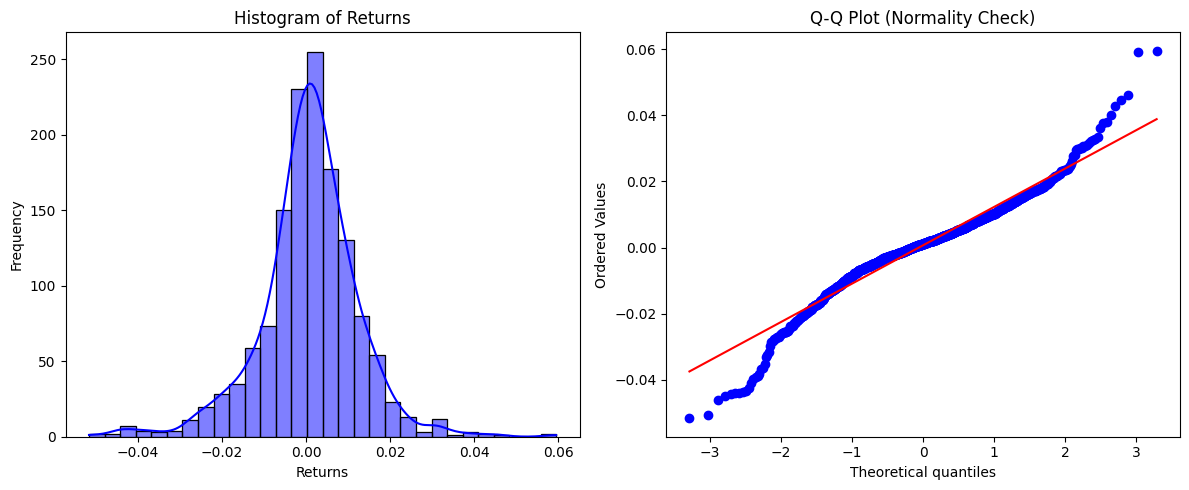

=== Normality Tests ===
Shapiro-Wilk Test: Statistic=0.9613, p-value=0.0000
Kolmogorov-Smirnov Test: Statistic=0.0777, p-value=0.0000
Jarque-Bera Test: Statistic=425.4686, p-value=0.0000
❌ The data does NOT follow a normal distribution (reject H0).


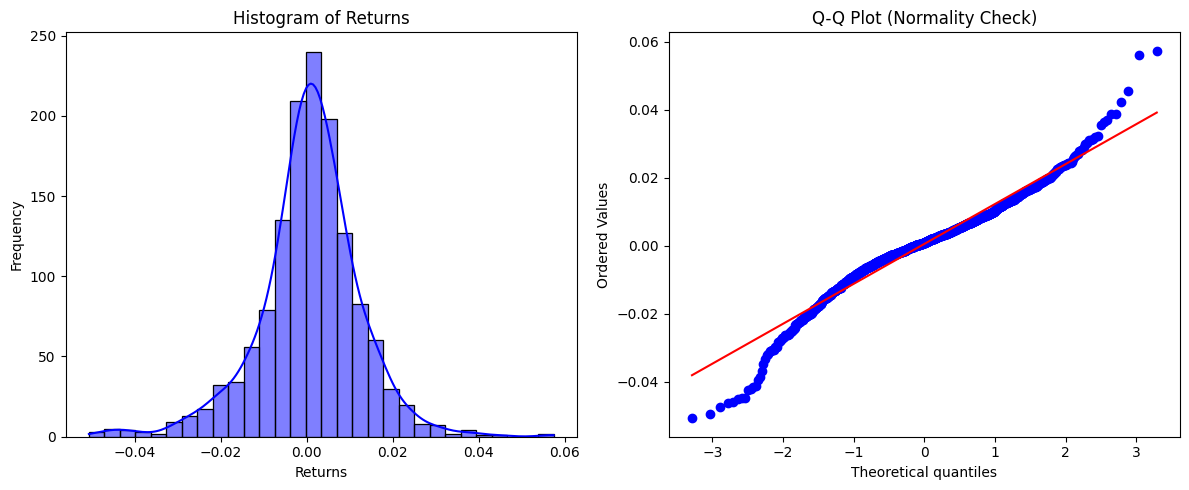

=== Normality Tests ===
Shapiro-Wilk Test: Statistic=0.9530, p-value=0.0000
Kolmogorov-Smirnov Test: Statistic=0.0813, p-value=0.0000
Jarque-Bera Test: Statistic=567.5649, p-value=0.0000
❌ The data does NOT follow a normal distribution (reject H0).


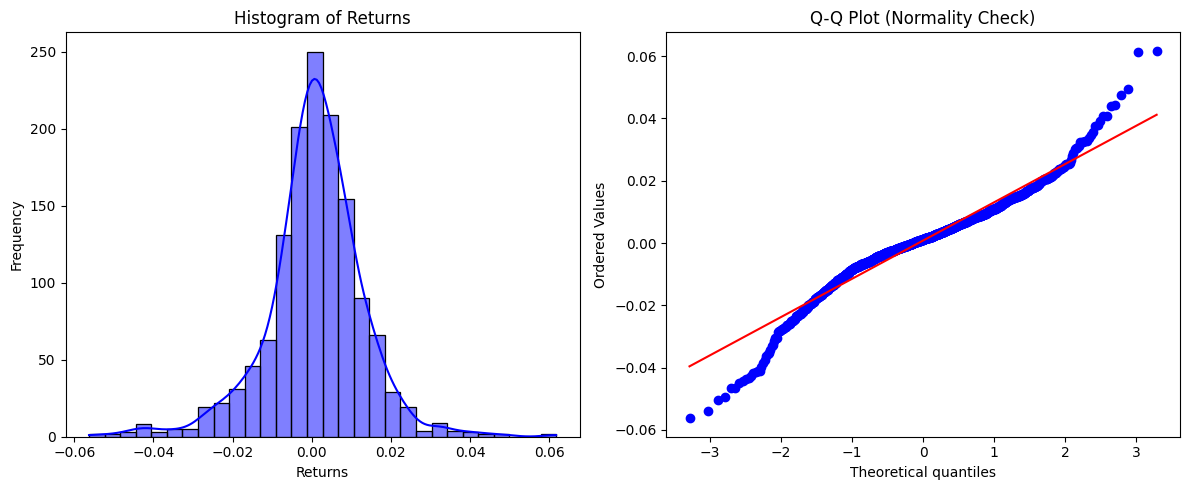

In [84]:
def check_normality(returns):
    """
    Checks for normality in the given array of returns using statistical tests and visualizations.
    
    Parameters:
        returns (numpy array or pandas series): Log returns or price returns.
    """
    
    print("=== Normality Tests ===")
    
    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = stats.shapiro(returns)
    print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
    
    # Kolmogorov-Smirnov Test (KS Test)
    ks_stat, ks_p = stats.kstest(returns, 'norm', args=(np.mean(returns), np.std(returns)))
    print(f"Kolmogorov-Smirnov Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

    # Jarque-Bera Test
    jb_stat, jb_p = stats.jarque_bera(returns)
    print(f"Jarque-Bera Test: Statistic={jb_stat:.4f}, p-value={jb_p:.4f}")

    # Interpretation
    alpha = 0.05
    if shapiro_p < alpha or ks_p < alpha or jb_p < alpha:
        print("❌ The data does NOT follow a normal distribution (reject H0).")
    else:
        print("✅ The data appears to be normally distributed (fail to reject H0).")

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram
    sns.histplot(returns, bins=30, kde=True, ax=ax[0], color='blue')
    ax[0].set_title("Histogram of Returns")
    ax[0].set_xlabel("Returns")
    ax[0].set_ylabel("Frequency")

    # Q-Q Plot
    stats.probplot(returns, dist="norm", plot=ax[1])
    ax[1].set_title("Q-Q Plot (Normality Check)")

    plt.tight_layout()
    plt.show()


print("Checking Normal Returns:")
check_normality(pf_returns_rp)
check_normality(pf_returns_mdp)
check_normality(pf_returns_ew)


